##ResNet50

- ResNet50(weights=None) - without pre-trained weights
- IMG_SIZE = 32
- BATCH_SIZE = 32
- EPOCHS = 30
- Lr = 0.0001

##Findings
Accuracy: 84.89%

#Mount Google Drive and import libraries

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models

Mounted at /content/drive


#Dataset

##Load training data

In [ ]:
# Define paths to dataset directories
train_dir = '/content/drive/My Drive/Data/GTSRB/Train/GTSRB/Final_Training/Images/'
test_dir = '/content/drive/My Drive/Data/GTSRB/Test/GTSRB/Final_Test/Images/'

# Define image size
IMG_SIZE = 32  # Resize images
BATCH_SIZE = 32
num_classes = 43

# Helper function to load images and labels
def load_data(data_dir):
    images = []
    labels = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    # Loop through each subdirectory (which corresponds to a class)
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)

        if os.path.isdir(label_path):
            label = int(label_dir)  # Subdirectory name is the class label

            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)

                # Check if the file has a valid image extension
                _, file_extension = os.path.splitext(img_file)
                if file_extension.lower() not in valid_extensions:
                    print(f"Skipping non-image file: {img_file}")
                    continue  # Skip non-image files (e.g., CSV)

                # Read the image using OpenCV
                image = cv2.imread(img_path)

                # Resize image
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

                # Append the image and label to the lists
                images.append(image)
                labels.append(label)

    # Convert to NumPy arrays and normalize
    images = np.array(images, dtype='float32') / 255.0  # Normalize images
    labels = to_categorical(labels, num_classes)  # One-hot encode labels

    return images, labels

# Load training data
images, labels = load_data(train_dir)

Skipping non-image file: GT-00000.csv
Skipping non-image file: GT-00001.csv
Skipping non-image file: GT-00002.csv
Skipping non-image file: GT-00003.csv
Skipping non-image file: GT-00004.csv
Skipping non-image file: GT-00005.csv
Skipping non-image file: GT-00006.csv
Skipping non-image file: GT-00007.csv
Skipping non-image file: GT-00008.csv
Skipping non-image file: GT-00009.csv
Skipping non-image file: GT-00010.csv
Skipping non-image file: GT-00011.csv
Skipping non-image file: GT-00012.csv
Skipping non-image file: GT-00013.csv
Skipping non-image file: GT-00014.csv
Skipping non-image file: GT-00015.csv
Skipping non-image file: GT-00016.csv
Skipping non-image file: GT-00017.csv
Skipping non-image file: GT-00018.csv
Skipping non-image file: GT-00019.csv
Skipping non-image file: GT-00020.csv
Skipping non-image file: GT-00021.csv
Skipping non-image file: GT-00022.csv
Skipping non-image file: GT-00023.csv
Skipping non-image file: GT-00024.csv
Skipping non-image file: GT-00025.csv
Skipping non

##Split dataset into train and validation set

In [ ]:
train_images, train_labels = images, labels

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')

Training data shape: (31367, 32, 32, 3)
Validation data shape: (7842, 32, 32, 3)


##Visualization of some images

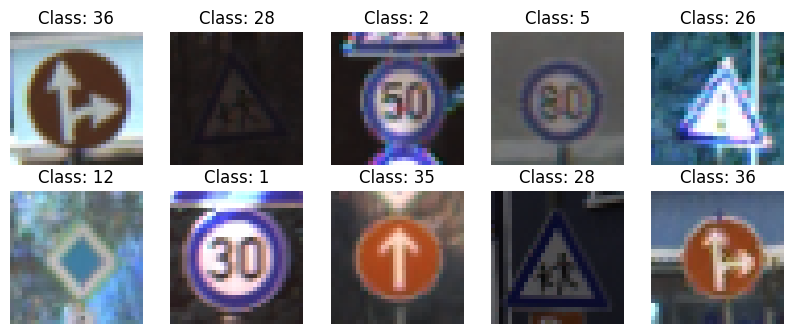

In [ ]:
import matplotlib.pyplot as plt

# Function to plot images
def plot_images(images, labels, num=10):
    plt.figure(figsize=(10, 10))
    for i in range(10):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f'Class: {np.argmax(labels[i])}')
        plt.axis('off')
    plt.show()

# Plot training images
plot_images(X_train, y_train)

##Data Transformation

In [ ]:
### Image Augmentation ###
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=15,        # Rotate images by up to 15 degrees
    zoom_range=0.2,           # Random zoom in/out by up to 20%
    width_shift_range=0.1,    # Shift the image horizontally by 10%
    height_shift_range=0.1,   # Shift the image vertically by 10%
)

# Fit the generator on the training data
datagen.fit(X_train)

# Create the augmented data generator for training
train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)

##Visualization of some Augmented Images

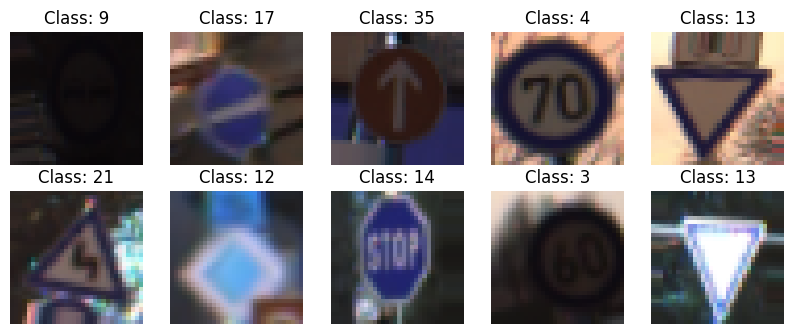

In [ ]:
import matplotlib.pyplot as plt

# Visualize some augmented images
augmented_images, augmented_labels = next(train_generator)

# Plot some examples
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(f'Class: {np.argmax(augmented_labels[i])}')
    plt.axis('off')
plt.show()

## Load test data

In [ ]:
# Load the test dataset
def load_test_data(test_dir):
    images = []
    img_names = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)

        # Check if the file is an image
        _, file_extension = os.path.splitext(img_file)
        if file_extension.lower() not in valid_extensions:
            print(f"Skipping non-image file: {img_file}")
            continue  # Skip non-image files

        # Read and resize the image
        image = cv2.imread(img_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        # Append the image and image file name to the lists
        images.append(image)
        img_names.append(img_file)

    # Convert images to a NumPy array
    images = np.array(images, dtype='float32') / 255.0  # Normalize images

    return images, img_names

# Load test images
X_test, test_img_names = load_test_data(test_dir)

Skipping non-image file: GT-final_test.test.csv


#Load ResNet50 model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load the pre-trained ResNet50 model
resnet = ResNet50(weights=None, include_top=False, input_shape= (IMG_SIZE, IMG_SIZE, 3))

x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = resnet.input, outputs = predictions)

##Compile and train the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the augmented data generator
history = model.fit(train_generator, validation_data=(X_val, y_val), epochs=50, steps_per_epoch=len(X_train) // BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 123s 68ms/step - accuracy: 0.3246 - loss: 2.5890 - val_accuracy: 0.4214 - val_loss: 10.9028
Epoch 2/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3438 - loss: 2.3509 - val_accuracy: 0.4204 - val_loss: 10.0708
Epoch 3/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.4088 - loss: 2.2185 - val_accuracy: 0.5979 - val_loss: 1.1907
Epoch 4/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4688 - loss: 2.1478 - val_accuracy: 0.5965 - val_loss: 1.1908
Epoch 5/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.5208 - loss: 1.6973 - val_accuracy: 0.6741 - val_loss: 2.2693
Epoch 6/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6250 - loss: 1.3057 - val_accuracy: 0.6725 - val_loss: 2.1821
Epoch 7/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.6006 - loss: 1.3754 - val_accuracy: 0.7464 - val_loss: 0.7725
Epoch 8/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6562 - loss: 0.8236 - val_a

#Evaluate the model

##Accuracy and Loss Curves
Visualisation of loss and accuracy over time (epochs).

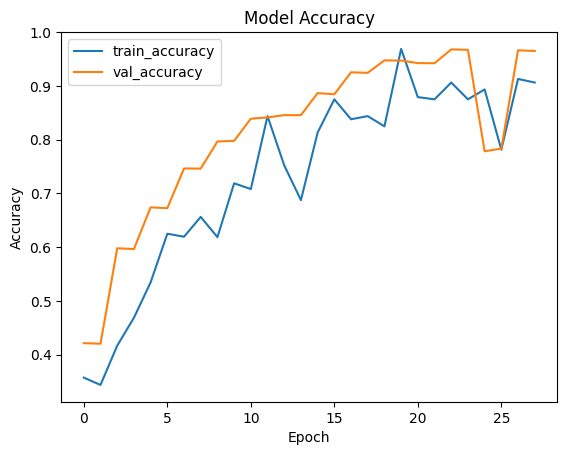

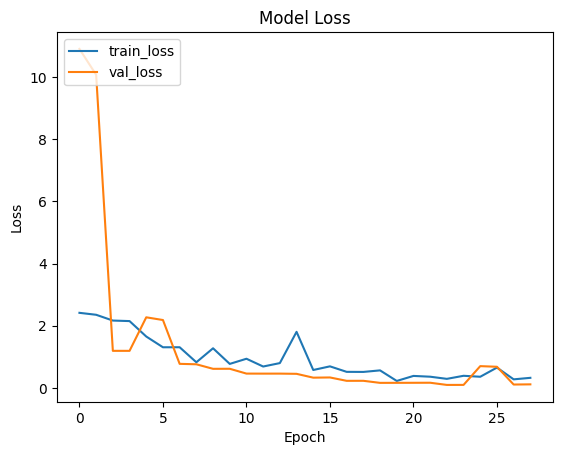

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Evaluate on test data
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_acc * 100:.2f}%')

246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9684 - loss: 0.0896
Validation accuracy: 96.79%


##Confusion Matrix

246/246 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step


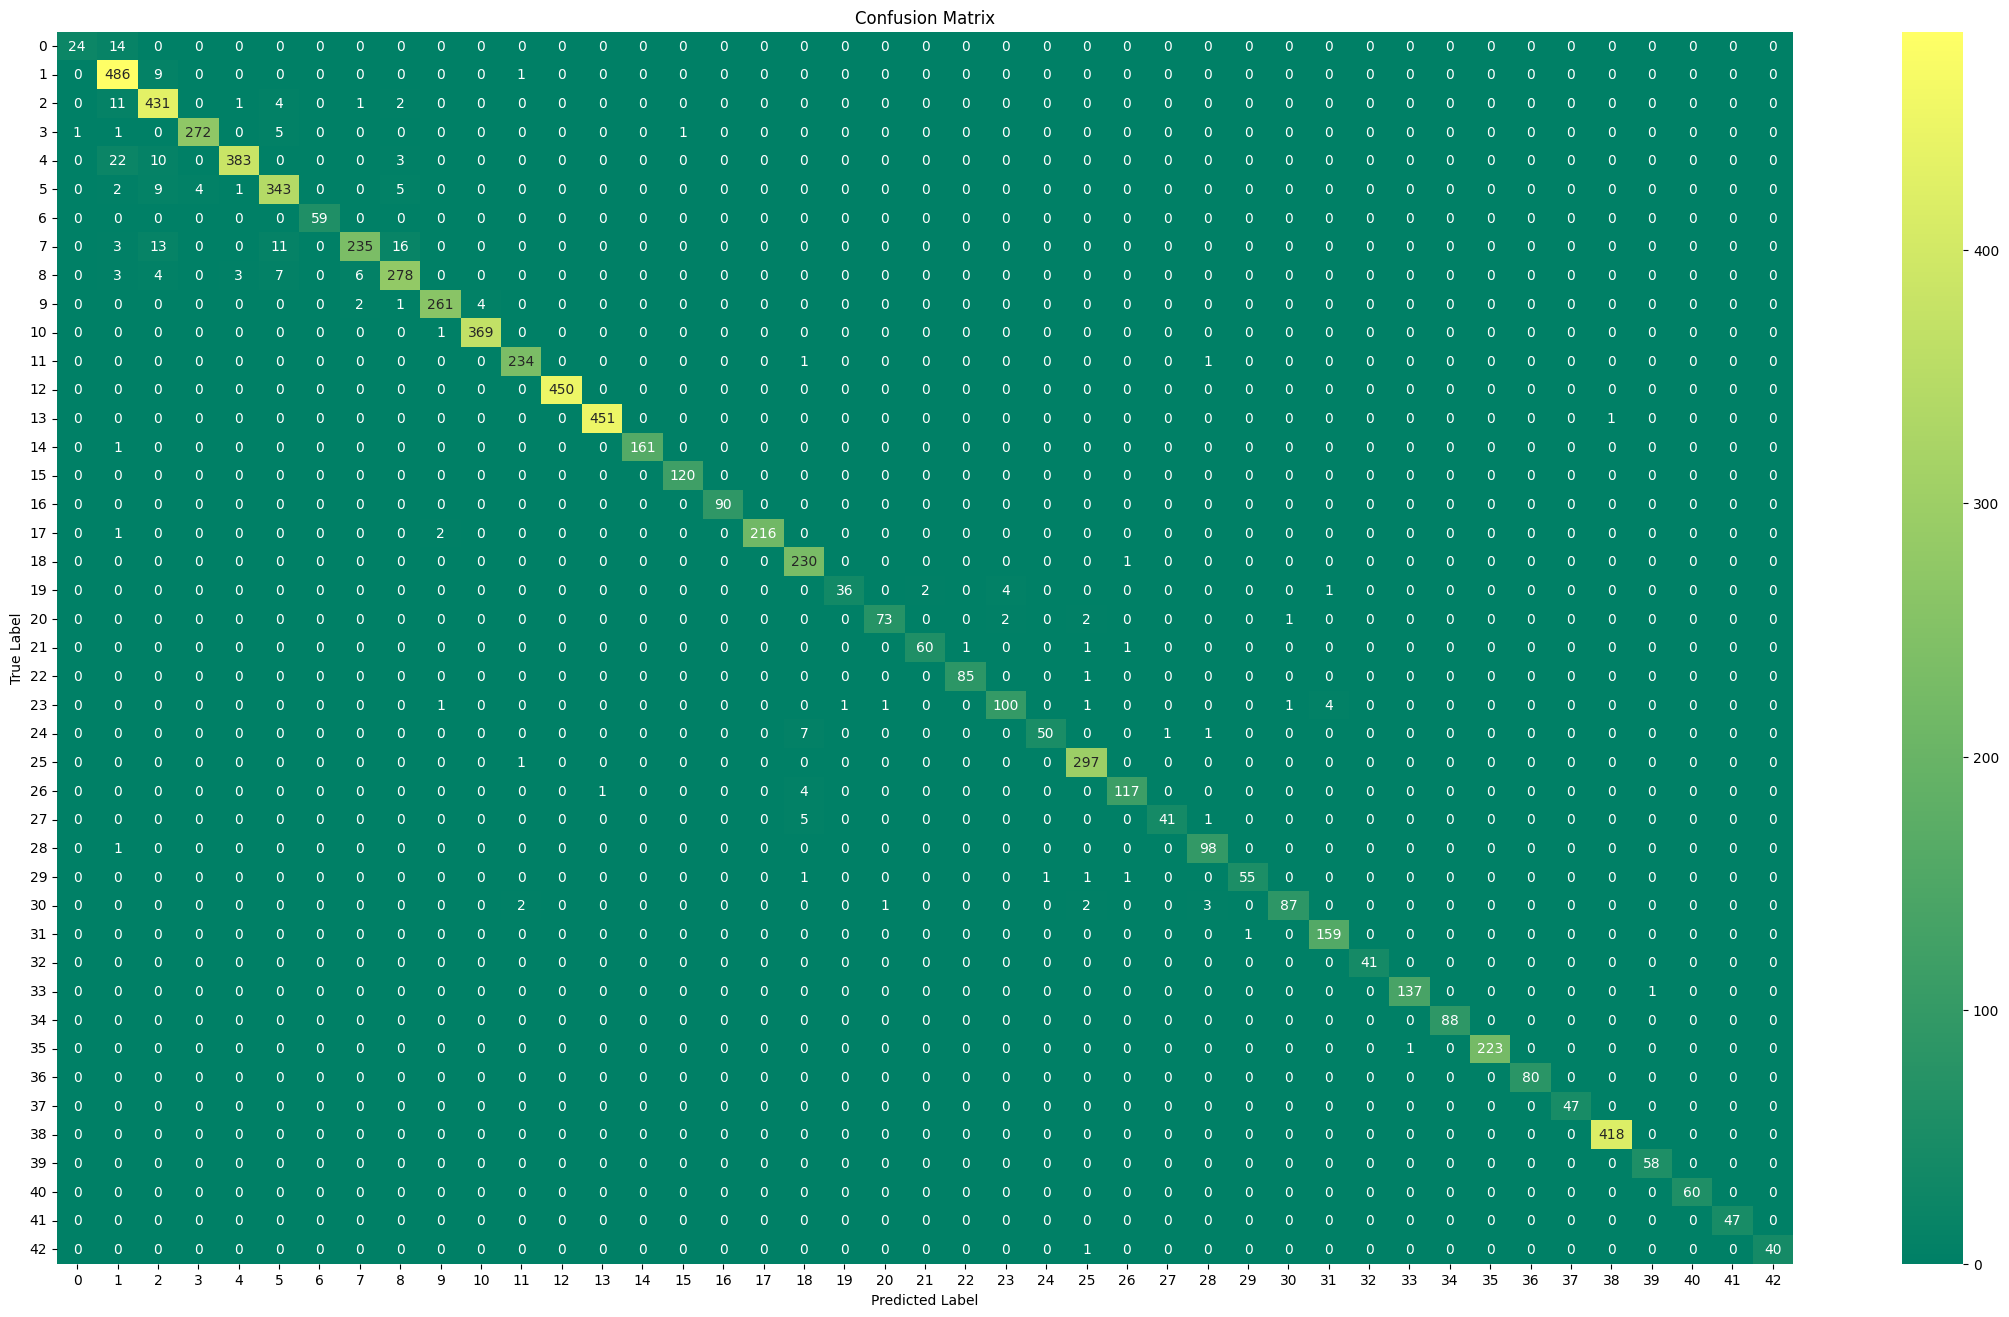

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get model predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize it using seaborn's heatmap
plt.figure(figsize=(28, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='summer')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks(rotation = 0)
plt.title('Confusion Matrix')
plt.show()

##Classification Report

In [ ]:
# Get model predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.63      0.76        38
           1       0.89      0.98      0.93       496
           2       0.91      0.96      0.93       450
           3       0.99      0.97      0.98       280
           4       0.99      0.92      0.95       418
           5       0.93      0.94      0.93       364
           6       1.00      1.00      1.00        59
           7       0.96      0.85      0.90       278
           8       0.91      0.92      0.92       301
           9       0.98      0.97      0.98       268
          10       0.99      1.00      0.99       370
          11       0.98      0.99      0.99       236
          12       1.00      1.00      1.00       450
          13       1.00      1.00      1.00       452
          14       1.00      0.99      1.00       162
          15       0.99      1.00      1.00       120
          16    

#Evaluate on test data (unseen data)

In [ ]:
# Path to test CSV file
test_csv_path = '/content/drive/My Drive/Data/GTSRB/Test/GTSRB/Final_Test/Images/GT-final_test.test.csv'
# Load the test labels from the CSV file
test_data = pd.read_csv(test_csv_path, sep=";")

In [ ]:
# Predict the class probabilities
predictions = model.predict(X_test)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


##Save test data

In [ ]:
# Create a DataFrame to save the image file names and predicted classes
result_df = pd.DataFrame({
    'Filename': test_img_names,
    'Predicted Class': predicted_classes
})

# Ensure the filenames are sorted in ascending order in the result file
result_df = result_df.sort_values(by='Filename')

# Save the results to a CSV file
result_df.to_csv('gtsrb_test_predictions.csv', index=False)
print("Predictions saved to 'gtsrb_test_predictions.csv'")

Predictions saved to 'gtsrb_test_predictions.csv'


##Print test accuracy

In [ ]:
import pandas as pd

# Load your predictions
predictions_df = pd.read_csv('gtsrb_test_predictions.csv')

# Load the ground truth file (downloaded separately)
ground_truth_df = pd.read_csv('/content/drive/My Drive/Data/GTSRB/GT-final_test.csv', sep=';')

# Merge both dataframes on the 'Filename' column
merged_df = pd.merge(predictions_df, ground_truth_df[['Filename', 'ClassId']], on='Filename')

# Calculate accuracy by comparing predicted classes with actual classes
accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 84.89%
